# Algorithms for Building and Manipulating Triplets of Hits

## Import and Prepare Data

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp

# External imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch_scatter import scatter_add
import time
import pandas as pd

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [2]:
%matplotlib inline

In [3]:
# Load by config file
config_file = '../configs/agnn_med.yaml'
config = load_config_file(config_file)
summaries = load_summaries(config)

In [7]:
%pwd

'/global/u2/d/danieltm/ExaTrkX/heptrkx-gnn-tracking/notebooks'

In [8]:
# Load by directory (preferred)
result_base = os.path.expandvars('/global/cscratch1/sd/danieltm/ExaTrkX/doublet_results')

In [9]:
result_name = 'agnn03'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pp(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/doublet_data/hitgraphs_med_000',
          'n_train': 2000,
          'n_valid': 20,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 3.0},
 'model': {'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 4,
           'name': 'agnn'},
 'n_ranks': 1,
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 45,
                                      'factor': 0.1,
                                      'start_epoch': 15},
                                     {'end_epoch': 64,
                                      'factor': 0.01,
                                      'start_epoch': 45}],
               'lr_scaling': 'sqrt',
               'lr_warmup_epochs': 5,
               'name': 'Adam'},
 'output_dir': 

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.00100,0.586104,2771.204409,110.572367,0,28.486812,0.592492,0.633848,0.564587
1,0.00100,0.583811,2858.860913,113.467192,1,27.793196,0.622164,0.673413,0.330643
2,0.00100,0.449013,2944.654240,116.943453,2,28.065021,0.325593,0.841056,0.339804
3,0.00100,0.341559,3010.028200,119.350692,3,28.650597,0.251842,0.883964,0.359094
4,0.00100,0.263951,3053.289420,121.042928,4,28.345083,0.318955,0.843807,0.330041
5,0.00100,0.293824,3086.119387,122.209467,5,28.175375,0.213713,0.906025,0.336945
6,0.00100,0.163868,3102.160514,122.722735,6,28.431455,0.149721,0.932066,0.353332
7,0.00100,0.162029,3126.568887,123.479624,7,28.524186,0.214245,0.901042,0.333970
8,0.00100,0.152849,3144.707661,124.143374,8,28.594389,0.162813,0.925556,0.341059
9,0.00100,0.179155,3173.045781,125.142804,9,28.562701,0.128173,0.933646,0.339416


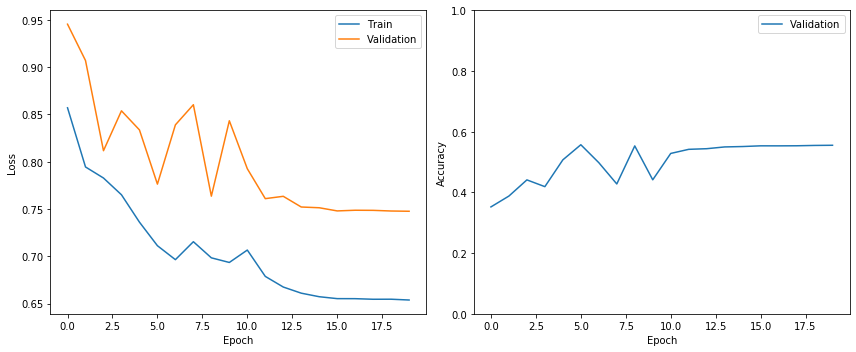

In [69]:
plot_train_history(summaries)

In [10]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
54,0.00001,0.071438,3279.973925,129.673661,54,28.846646,0.079155,0.964403,0.345899


In [11]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    

In [12]:
n_phi_sections = 4
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [13]:
# Load the test dataset
n_test = 3
test_loader = get_test_data_loader(config, n_test=n_test)

In [14]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 3.25 s, sys: 42.3 ms, total: 3.3 s
Wall time: 1.65 s


In [22]:
i = 2

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
pid = g.pid.numpy()
y = g.y.numpy()
o = test_preds[i].numpy()

## Investigate a particular event

In [23]:
pid

array([0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 9.007213e+17,
       0.000000e+00, 0.000000e+00])

In [17]:
e.shape

(2, 20671)

In [121]:
start, end = e

## An efficient triplet constructor

Given the edge indices, re-construct the adjecency matrices (this is a little inefficient, given these had been previously constructed - but it's a quick process). 

In [18]:
A = e
start, end = A
Ri = np.zeros((np.max(A)+1, A.shape[1]))
Ro = np.zeros((np.max(A)+1, A.shape[1]))
Ri[A[0,:], np.arange(A.shape[1])]=1
Ro[A[1,:], np.arange(A.shape[1])]=1

Convert the adjacency matrices into a triplet index matrix (the analogue of the edge index matrix). This is done efficiently by finding the indices where the adjacency index is non-zero, for each row, and then arranging all combinations of those, row-by-row. This algorithm is predominantly my own construction, so it may have edge cases I haven't considered.

In [ ]:
tic = time.time()
Riwhere = [np.nonzero(t)[0] for t in Ri]
Rowhere = [np.nonzero(t)[0] for t in Ro]
Riwhere, Rowhere
E = [np.stack(np.meshgrid(j, i),-1).reshape(-1,2) for i,j in zip(Riwhere, Rowhere)]
triplets2 = np.concatenate(E).T
toc = time.time()
print("Elapsed: ", toc-tic, " triplets2 shape: ", triplets2.shape)

We can confirm its efficiency (and sanity check it) by comparing to a brute force list comprehension approach.

In [1]:
tic = time.time()
triplets = np.transpose(np.array([[key1,key2] for key1, val1 in enumerate(start) for key2, val2 in enumerate(end) if val1 == val2]))
toc = time.time()
print("Elapsed: ", toc-tic, " triplets shape: ", triplets.shape)

NameError: name 'time' is not defined

In [20]:
triplets2.shape

(2, 86202)

In [30]:
triplet_y = np.zeros(triplets2.shape[1], dtype=np.float32)
triplet_y[:] = (pid[triplets2[0]] == pid[triplets2[1]]) * (pid[triplets2[0]] != 0)

## A mistake in the truth vector logic

Here I need to iron out an error when producing the triplet truth vector from the edge PIDs.

In [99]:
pid['pid'].shape

(5796,)

In [97]:
pid.items

<bound method Mapping.items of <numpy.lib.npyio.NpzFile object at 0x7fdeb9879160>>

In [51]:
np.where(triplet_y)[0].shape

(2843,)

In [7]:
A = torch.tensor(np.random.rand(10,3))

In [19]:
A.sum(dim=0)

tensor([3.5595, 5.6303, 6.4801], dtype=torch.float64)

In [10]:
A

tensor([[0.3698, 0.9084, 0.4024],
        [0.1876, 0.7989, 0.7748],
        [0.4290, 0.9116, 0.6302],
        [0.1675, 0.3373, 0.7296],
        [0.4792, 0.6122, 0.5679],
        [0.5744, 0.4236, 0.9787],
        [0.1216, 0.0673, 0.5149],
        [0.3724, 0.2014, 0.5201],
        [0.0869, 0.9985, 0.7820],
        [0.7709, 0.3712, 0.5793]], dtype=torch.float64)